In [172]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [173]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [174]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [175]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [176]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda 
def soft_thresholding_operator(x, lambda_):
    if x > 0.0 and lambda_ < abs(x):
        return x - lambda_
    elif x < 0.0 and lambda_ < abs(x):
        return x + lambda_
    else:
        return 0.0

def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    w0 = np.mean(y)
    
    if draw_curve:
        losses = []

    for iteration in range(max_iter):
        w_old = [None]*n_features
        for j in range(n_features):
            w_old[j] = w[j]
            w_j_old = w[j]
            r_j = y - np.dot(X, w) + X[:, j] * w_j_old
            w[j] = soft_thresholding_operator(np.dot(X[:, j], r_j), lmda) / (np.dot(X[:, j], X[:, j]) + 1.0e-10)

        w0 = np.mean(y - np.dot(X, w))
        

        #print(f"w_j_old: {w_j_old}")
        w_change = np.sum(w - w_old) #.max
        #w0_change = np.abs(w0 - w0_old)

        #print(f"w_change_matrix: {np.sum(np.abs(w) - np.abs(w_j_old))}")
        print(f"w_change: {w_change}")

        if draw_curve:
            loss = 0.5 * np.sum((y - np.dot(X, w) - w0) ** 2) + lmda * np.sum(np.abs(w))
            losses.append(loss)

        # Check convergence
        if abs(w_change) < epsilon:
            print("broken from epsilon")
            break
    if draw_curve:
        import matplotlib.pyplot as plt
        plt.plot(losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Lasso Regression Loss Curve')
        plt.show()

    return (w,w0)

In [177]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

w_change: 3.474912661379047
w_change: 1.743278125640003
w_change: 1.45206888852517
w_change: 2.0821052000476907
w_change: 1.2339527572190447
w_change: 0.41169989499005577
w_change: 0.01820791571554399
w_change: -0.004633186475223738
broken from epsilon


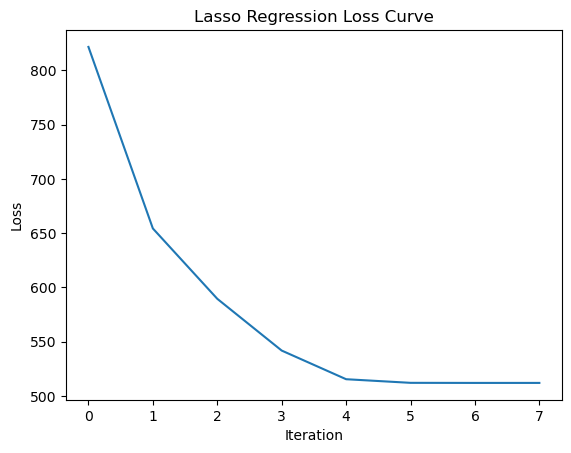

[ 9.82655009e+00 -9.70577737e+00 -9.71222330e+00  9.81846783e+00
  9.89506918e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.41887375e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.55408071e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.28297690e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.31350439e-03  0.00000000e+00
 -1.23270975e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.29388207e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [178]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

In [181]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    y_pred = np.dot(X, w) + w0
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Calculate sparsity
    sparsity_w = np.sum(w != 0)
    
    # Calculate precision and recall
    precision_w = precision_score(w_true != 0, w != 0)
    recall_w = recall_score(w_true != 0, w != 0)
    
    return rmse, sparsity_w, precision_w, recall_w

n = 50
d = 75
k = 5
sigma = 1.0
w0 = 0.0
seed = 256

X, y, w_true, w0_true = DataGenerator(n, d, k, sigma, w0, seed)

# Compute initial weights
w, w0 = Initialw(X, y)

Emetric = Evaluate(X, y, w, w0, w_true, w0_true)


In [182]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w, w0, w_true, w0_true)

In [205]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    num_lambdas = 50
    max_lambda = np.max(np.abs(X.T @ (y - np.mean(y))))
    print(f"max_lambda: {max_lambda}")
    lambdas = np.linspace(0, max_lambda, num=num_lambdas)
    w, w0 = lasso(X, y, lmda=10.0, draw_curve=True)

    features = X.shape[1]
    W = np.zeros((num_lambdas, features))
    W0 = np.zeros(num_lambdas)
    for i, lambda_ in enumerate(lambdas):
        w, w0 = lasso(X, y, lmda=lambda_)
        W[i] = w
        W0[i] = w0

    plt.figure(figsize=(10, 6))
    for j in range(features):
        plt.plot(lambdas, W[:, j], label=f'Feature {j+1}', color=plt.cm.viridis(j / features))
    
    plt.title('Lasso Solution Path')
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)
    plt.grid(True)
    plt.show()

    return W, W0, lambdas

In [206]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    n_lambdas= len(Lmda)
    RMSE= np.zeros(n_lambdas)
    Sparsity= np.zeros(n_lambdas)
    Precision= np.zeros(n_lambdas)
    Recall= np.zeros(n_lambdas)
    
    for i in range(n_lambdas):
        w, w0= W[i], W0[i]
        RMSE[i], Sparsity[i], Precision[i], Recall[i] = Evaluate(X, y, w, w0, w_true, w0_true)
        
    plt.title('Precision and Recall vs Lambda')
    plt.figure(figsize=(10,6))
    plt.plot(Lmda, Precision, label= 'Precision')
    plt.plot(Lmda, Recall, label= 'Recall')
    plt.xlabel('Lambda')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    
    
    return (RMSE, Sparsity, Precision, Recall)

In [207]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

In [208]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

In [209]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)

In [164]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

Lambda values: 
 [ 3.9578254   5.8325848   7.7073442   9.5821036  11.456863   13.3316224
 15.20638181 17.08114121 18.95590061 20.83066001 22.70541941 24.58017881
 26.45493821 28.32969761 30.20445701 32.07921641 33.95397581 35.82873521
 37.70349461 39.57825401]


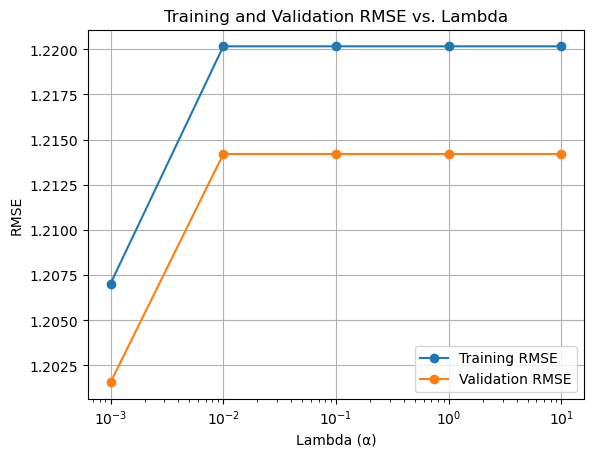

Best Lambda: 0.001
Smallest Validation RMSE: 1.2015646596676801
Test RMSE with Best Lambda: 1.205578686482247 

Top-10 features with the largest magnitude in the Lasso solution:
servers are 0.0
salad and the 0.0
and lots 0.0
rolls and 0.0
good we 0.0
you have -0.0
however -0.0
no -1.0696902676804274
great 3.35649993639197
not -9.784600830603429


In [144]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def Validation(X_train, y_train, X_valid, y_valid):
    y_bar = np.mean(y_train)

# Step 2: Calculate the difference between each element of y and ¯y
    y_diff = y_train - y_bar

# Step 3: Compute the maximum absolute value of the resulting vector
    lambda_max = np.max(np.abs(y_diff @ X_train))

# Step 4: Generate a range of 20 lambda values
    lambda_values = np.linspace(0.1 * lambda_max, lambda_max, 20)

    print("Lambda values:", '\n', lambda_values)

    lambda_values = range(0, 20)
    rmse_train_values = []
    rmse_valid_values = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        
        # Training RMSE
        y_train_pred = lasso.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_train_values.append(rmse_train)

        # Validation RMSE
        y_valid_pred = lasso.predict(X_valid)
        rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
        rmse_valid_values.append(rmse_valid)
        
    return alphas, rmse_train_values, rmse_valid_values

# Assuming X_train, y_train, X_valid, y_valid are defined and contain data

lambda_values, rmse_train_values, rmse_valid_values = Validation(X_train, y_train, X_valid, y_valid)

# Plot RMSE vs. Lambda
plt.plot(lambda_values, rmse_train_values, marker='o', label='Training RMSE')
plt.plot(lambda_values, rmse_valid_values, marker='o', label='Validation RMSE')
plt.xlabel('Lambda (α)')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE vs. Lambda')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

def find_best_lambda(X_train, y_train, X_valid, y_valid, X_test, y_test, lambda_values):
    best_lambda = None
    best_model = None
    smallest_rmse = float('inf')

    for lambda_val in lambda_values:
        # Train Lasso model
        lasso = Lasso(alpha=lambda_val)
        lasso.fit(X_train, y_train)

        # Predict on validation set
        y_pred_valid = lasso.predict(X_valid)

        # Compute validation RMSE
        rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

        # Check if this lambda value gives the smallest validation RMSE
        if rmse_valid < smallest_rmse:
            smallest_rmse = rmse_valid
            best_lambda = lambda_val
            best_model = lasso

    # Predict on test set using the best model
    y_pred_test = best_model.predict(X_test)
    
    # Compute test RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return best_lambda, smallest_rmse, test_rmse, best_model

# Assuming lambda_values is a list/array of lambda values

best_lambda, smallest_rmse, test_rmse, best_model = find_best_lambda(X_train, y_train, X_valid, y_valid, X_test, y_test, lambda_values)

print("Best Lambda:", best_lambda)
print("Smallest Validation RMSE:", smallest_rmse)
print("Test RMSE with Best Lambda:", test_rmse, '\n')

w_lasso = best_model.coef_
top_10_indices = np.argsort(np.abs(w_lasso))[-10:]
top_10_features = [fName[i] for i in top_10_indices]

#top-10 features along with their corresponding coefficients
print("Top-10 features with the largest magnitude in the Lasso solution:")
for feature, coefficient in zip(top_10_features, w_lasso[top_10_indices]):
    print(feature, coefficient)

In [138]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('/Users/karolina/Desktop/Machine Learning/hw3/data/star_data.mtx', '/Users/karolina/Desktop/Machine Learning/hw3/data/star_labels.txt', '/Users/karolina/Desktop/Machine Learning/hw3/data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

print(w_lasso, len(w_lasso))

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
[0.001, 0.01, 0.1, 1, 10] 5
Lambda values: [ 3.9578254   5.8325848   7.7073442   9.5821036  11.456863   13.3316224
 15.20638181 17.08114121 18.95590061 20.83066001 22.70541941 24.58017881
 26.45493821 28.32969761 30.20445701 32.07921641 33.95397581 35.82873521
 37.70349461 39.57825401]
Lasso select features:
place if 10
as well 1
both times 0.1
## hours 0.01
goodies 0.001


IndexError: index 5 is out of bounds for axis 0 with size 5